

## Machine Learning 31009 2 - Final Project
### Team 15: Jeffrey(Yan) Chen, Olivia(Caixin) Yang, Wilson McDermott, Zhizhuo Li



In [1]:
#import necessary libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

import os, glob
from tensorflow.keras.preprocessing import image

/Users/yanchen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [ ]:
print(tf.__version__)

2.5.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Face Detection - Set Up

### Using haar cascade to detect faces
Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images. We'll be using a Haar Cascade Model trained to detect faces in order to obtain the bounding box coordinates of faces in an image.

In [ ]:
#face_model = cv2.CascadeClassifier('/content/drive/MyDrive/haarcascades/haarcascade_frontalface_default.xml')
face_model = cv2.CascadeClassifier('/content/drive/MyDrive/Machine Learning/haarcascades/haarcascade_frontalface_default.xml')

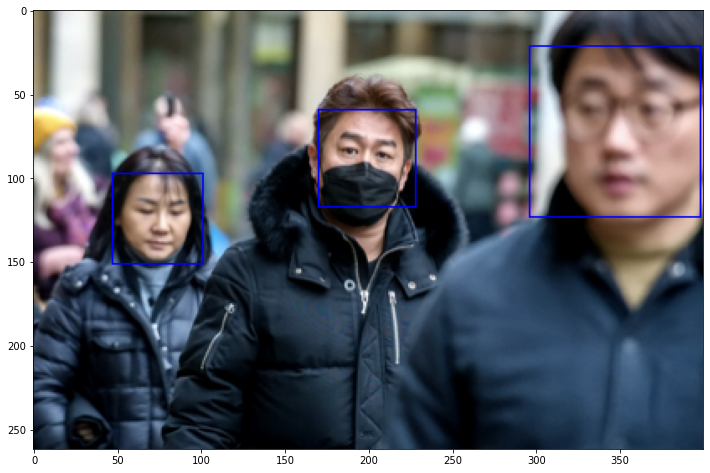

In [ ]:
#img = cv2.imread('/content/drive/MyDrive/Mask_Data/images/maksssksksss244.png')
img = cv2.imread('/content/drive/MyDrive/Machine Learning/Face Mask/images/maksssksksss244.png')
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

In our project, we will use Haar feature-based cascade classifiers to detect faces and then train image classification models to identify masks. 

## 2. Load Data

### 2.1 Load Image 

In [ ]:
#data augmentation with shear_range, zoom_range, horizontal_flip

#base_dir = '/content/drive/MyDrive/Face Mask Dataset'
base_dir = '/content/drive/MyDrive/Machine Learning/Face Mask Dataset'
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

train_generator = train_gen.flow_from_directory(directory=base_dir+'/Train',
                                                    target_size=(128,128),
                                                    class_mode='categorical',
                                                    batch_size=32)

Found 10009 images belonging to 2 classes.


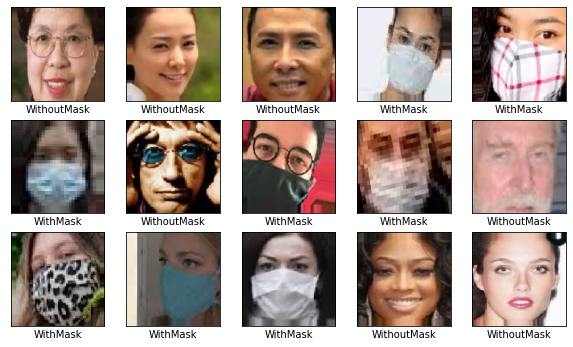

In [ ]:
class_names = {v:k for k,v in train_generator.class_indices.items()}
images,labels = next(iter(train_generator))

plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[labels[i][1]])

plt.show()

### 2.2 Load Train, Validation, & Test Data

In [ ]:
mask_train_dir='/content/drive/MyDrive/Machine Learning/Face Mask Dataset/Train/WithMask'
no_mask_train_dir='/content/drive/MyDrive/Machine Learning/Face Mask Dataset/Train/WithoutMask'
mask_valid_dir='/content/drive/MyDrive/Machine Learning/Face Mask Dataset/Validation/WithMask'
no_mask_valid_dir='/content/drive/MyDrive/Machine Learning/Face Mask Dataset/Validation/WithoutMask'
mask_test_dir='/content/drive/MyDrive/Machine Learning/Face Mask Dataset/Test/WithMask'
no_mask_test_dir='/content/drive/MyDrive/Machine Learning/Face Mask Dataset/Test/WithoutMask'



dirlist=[mask_train_dir, no_mask_train_dir, mask_valid_dir, no_mask_valid_dir, mask_test_dir, no_mask_test_dir]
classes=['mask', 'no_mask', 'mask', 'no_mask', 'mask', 'no_mask']
filepaths=[]
labels=[]

for d,c in zip(dirlist, classes):
    flist=os.listdir(d)
    for f in flist:
        fpath=os.path.join (d,f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  11801    labels:  11801


In [ ]:
#check the labels 
Fseries=pd.Series(filepaths, name='file_paths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)
#df=pd.DataFrame(np.array(df).reshape(11792,2), columns = ['file_paths', 'labels'])
df=pd.DataFrame(np.array(df).reshape(11801,2), columns = ['file_paths', 'labels'])
print(df['labels'].value_counts())

no_mask    5918
mask       5883
Name: labels, dtype: int64


In [ ]:
#split the train set and validation set with 0.9 
train_df, test_df=train_test_split(df, train_size=0.9 , shuffle=True)
train_df, valid_df=train_test_split(train_df, train_size=0.9, shuffle=True)

print(train_df.labels.value_counts())
print(valid_df.labels.value_counts())
print(test_df.labels.value_counts())

no_mask    4796
mask       4762
Name: labels, dtype: int64
mask       540
no_mask    522
Name: labels, dtype: int64
no_mask    600
mask       581
Name: labels, dtype: int64


In [ ]:
target_size=(128,128)
batch_size=32

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input, 
    zoom_range=0.2, 
    rotation_range=40)
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='file_paths', 
    y_col='labels', 
    target_size=target_size, 
    batch_size=batch_size, 
    color_mode='rgb', 
    class_mode='categorical')
valid_gen = test_datagen.flow_from_dataframe(
    valid_df, 
    x_col='file_paths', 
    y_col='labels', 
    target_size=target_size, 
    batch_size=batch_size, 
    color_mode='rgb', 
    class_mode='categorical')
test_gen = test_datagen.flow_from_dataframe(
    test_df, 
    x_col='file_paths', 
    y_col='labels', 
    target_size=target_size, 
    batch_size=batch_size, 
    color_mode='rgb', 
    class_mode='categorical')

Found 9558 validated image filenames belonging to 2 classes.
Found 1062 validated image filenames belonging to 2 classes.
Found 1181 validated image filenames belonging to 2 classes.


### 2.3 Data Shape

In [ ]:
train_gen.class_indices

{'mask': 0, 'no_mask': 1}

In [ ]:
train_gen.image_shape

(128, 128, 3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


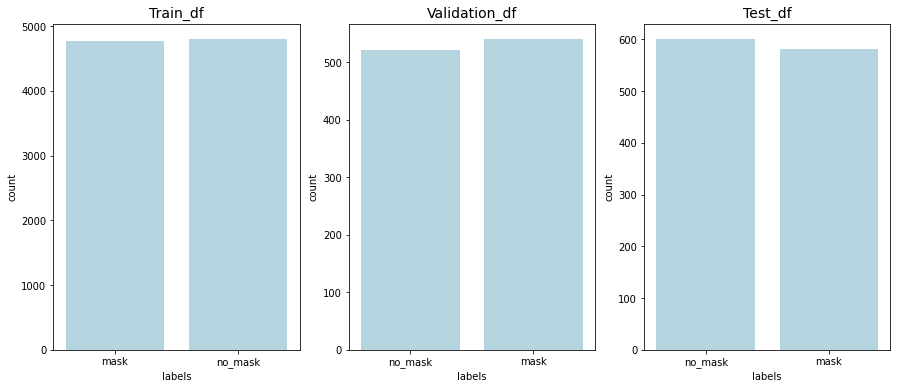

In [ ]:
plt.figure(figsize = (15,6))
plt.subplot(1,3,1)
sns.countplot(train_df["labels"],color='lightblue')
plt.title("Train_df", size = 14)

plt.subplot(1,3,2)
sns.countplot(valid_df["labels"],color='lightblue')
plt.title("Validation_df", size = 14)

plt.subplot(1,3,3)
sns.countplot(test_df["labels"],color='lightblue')
plt.title("Test_df", size = 14)

plt.show()

## 3. CNN Model

A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other.

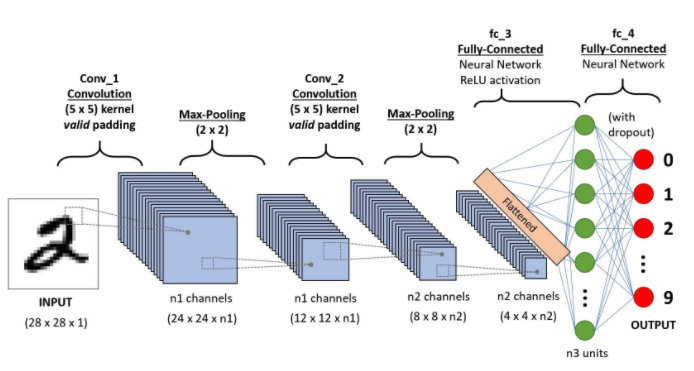

### 3.1 Model 1 - CNN1

In [ ]:
# CNN model with all sigmoid activation functions
CNN_model1 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', input_shape=(128,128,3)),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Conv2D(64,(3,3), activation = 'sigmoid'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3), activation = 'sigmoid'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(128, activation='sigmoid'), 
        tf.keras.layers.Dense(2, activation='sigmoid')
        ])

In [ ]:
CNN_model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [ ]:
CNN_model1.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [ ]:
history_CNN1 = CNN_model1.fit_generator(generator = train_gen,
                                      validation_data = valid_gen,
                                      epochs = 10,
                                      steps_per_epoch = 10,
                                      validation_steps = 10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
10/10 [==============================] - 233s 23s/step - loss: 1.7230 - accuracy: 0.4781 - val_loss: 1.6683 - val_accuracy: 0.5156
Epoch 2/10
10/10 [==============================] - 176s 18s/step - loss: 1.6285 - accuracy: 0.5063 - val_loss: 1.5155 - val_accuracy: 0.5219
Epoch 3/10
10/10 [==============================] - 144s 15s/step - loss: 1.5682 - accuracy: 0.4719 - val_loss: 1.4267 - val_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 125s 13s/step - loss: 1.3654 - accuracy: 0.5000 - val_loss: 1.2878 - val_accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - 114s 12s/step - loss: 1.2219 - accuracy: 0.5031 - val_loss: 1.1577 - val_accuracy: 0.5000
Epoch 6/10
10/10 [==============================] - 98s 10s/step - loss: 1.0431 - accuracy: 0.5406 - val_loss: 1.0049 - val_accuracy: 0.5250
Epoch 7/10
10/10 [==============================] - 95s 10s/step - loss: 0.9933 - accuracy: 0.4969 - val_loss: 0.8945 - val_accuracy: 0.5344
Epoch 8/

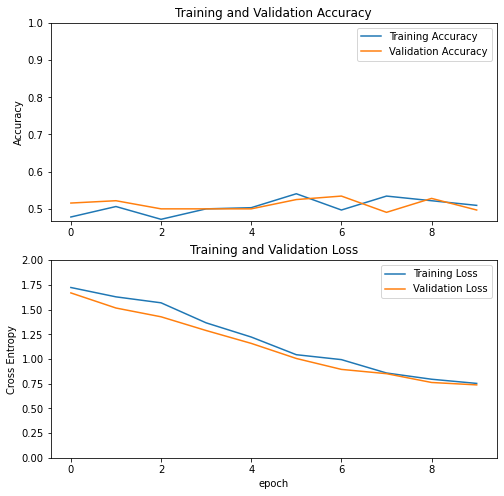

In [ ]:
acc = history_CNN1.history['accuracy']
val_acc = history_CNN1.history['val_accuracy']

loss = history_CNN1.history['loss']
val_loss = history_CNN1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
import time
start = time.time()
prediction1 = CNN_model1.predict(test_gen)
end = time.time()
CNN_test_time1 = end - start

In [ ]:
CNN_test_time1

371.10720205307007

In [ ]:
CNN_test_loss1, CNN_test_acc1 = CNN_model1.evaluate_generator(test_gen)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [ ]:
CNN_test_loss1, CNN_test_acc1

(0.7399072051048279, 0.49195596575737)

In [ ]:
CNN_model1.save('cnn1.h5')

### 3.2 Model 2 - CNN2

In [ ]:
# cnn model with all relu activation functions and last layer is sigmoid function
CNN_model2 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dense(2, activation='sigmoid') 
        ])

In [ ]:
CNN_model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)            

In [ ]:
CNN_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [ ]:
history_CNN2 = CNN_model2.fit_generator(generator = train_gen,
                                      validation_data = valid_gen,
                                      epochs = 10,
                                      steps_per_epoch = 10,
                                      validation_steps = 10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
10/10 [==============================] - 69s 7s/step - loss: 0.4742 - accuracy: 0.7781 - val_loss: 0.2723 - val_accuracy: 0.8875
Epoch 2/10
10/10 [==============================] - 67s 7s/step - loss: 0.3094 - accuracy: 0.8625 - val_loss: 0.2212 - val_accuracy: 0.9187
Epoch 3/10
10/10 [==============================] - 61s 6s/step - loss: 0.2470 - accuracy: 0.8969 - val_loss: 0.2063 - val_accuracy: 0.9250
Epoch 4/10
10/10 [==============================] - 68s 7s/step - loss: 0.2834 - accuracy: 0.8906 - val_loss: 0.1691 - val_accuracy: 0.9469
Epoch 5/10
10/10 [==============================] - 62s 6s/step - loss: 0.2353 - accuracy: 0.9156 - val_loss: 0.1267 - val_accuracy: 0.9563
Epoch 6/10
10/10 [==============================] - 61s 6s/step - loss: 0.2355 - accuracy: 0.9062 - val_loss: 0.1763 - val_accuracy: 0.9187
Epoch 7/10
10/10 [==============================] - 62s 6s/step - loss: 0.1804 - accuracy: 0.9500 - val_loss: 0.1217 - val_accuracy: 0.9438
Epoch 8/10
10/10 [==

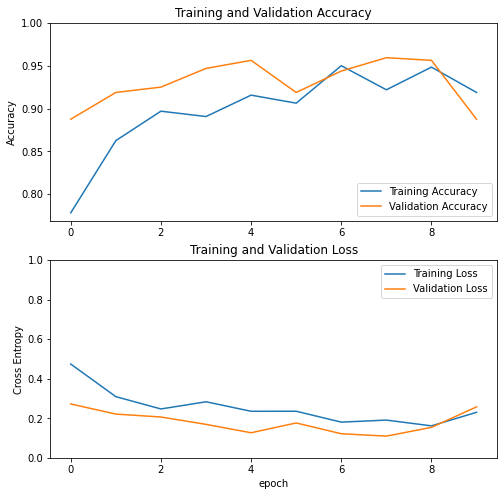

In [ ]:
acc = history_CNN2.history['accuracy']
val_acc = history_CNN2.history['val_accuracy']

loss = history_CNN2.history['loss']
val_loss = history_CNN2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
start = time.time()
prediction2 = CNN_model2.predict(test_gen)
end = time.time()
CNN_test_time2 = end - start

In [ ]:
CNN_test_time2

2.9594085216522217

In [ ]:
CNN_test_loss2, CNN_test_acc2 = CNN_model2.evaluate_generator(test_gen)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [ ]:
CNN_test_loss2, CNN_test_acc2

(0.3025452792644501, 0.8636748790740967)

In [ ]:
CNN_model2.save('cnn2.h5')

### 3.3 Model 3 - CNN3

In [ ]:
# cnn model based on previous model with drooput layers to prevent overfitting and act as the regularization
CNN_model3 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape=(128,128,3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dense(2, activation='sigmoid') 
        ])

In [ ]:
CNN_model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)       

In [ ]:
CNN_model3.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [ ]:
history_CNN3 = CNN_model3.fit_generator(generator = train_gen,
                                      validation_data = valid_gen,
                                      epochs = 10,
                                      steps_per_epoch = 10,
                                      validation_steps = 10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
10/10 [==============================] - 52s 5s/step - loss: 0.7823 - accuracy: 0.6344 - val_loss: 0.5661 - val_accuracy: 0.7719
Epoch 2/10
10/10 [==============================] - 43s 5s/step - loss: 0.4169 - accuracy: 0.8406 - val_loss: 0.3395 - val_accuracy: 0.8844
Epoch 3/10
10/10 [==============================] - 47s 5s/step - loss: 0.3774 - accuracy: 0.8687 - val_loss: 0.3922 - val_accuracy: 0.8500
Epoch 4/10
10/10 [==============================] - 41s 4s/step - loss: 0.3010 - accuracy: 0.8844 - val_loss: 0.3064 - val_accuracy: 0.9219
Epoch 5/10
10/10 [==============================] - 42s 4s/step - loss: 0.2667 - accuracy: 0.9062 - val_loss: 0.2249 - val_accuracy: 0.9375
Epoch 6/10
10/10 [==============================] - 45s 5s/step - loss: 0.2451 - accuracy: 0.9094 - val_loss: 0.2772 - val_accuracy: 0.9031
Epoch 7/10
10/10 [==============================] - 36s 4s/step - loss: 0.1863 - accuracy: 0.9419 - val_loss: 0.1989 - val_accuracy: 0.9406
Epoch 8/10
10/10 [==

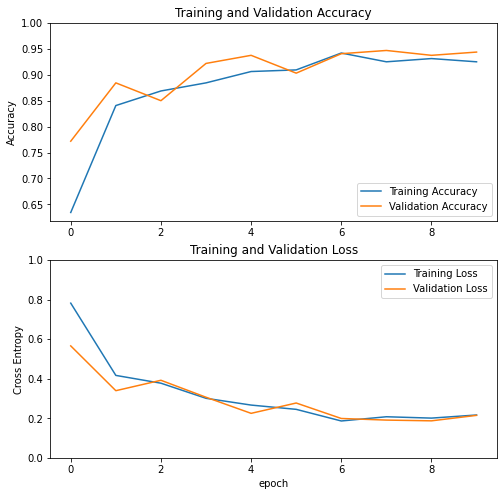

In [ ]:
acc = history_CNN3.history['accuracy']
val_acc = history_CNN3.history['val_accuracy']

loss = history_CNN3.history['loss']
val_loss = history_CNN3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
start = time.time()
prediction3 = CNN_model3.predict(test_gen)
end = time.time()
CNN_test_time3 = end - start

In [ ]:
CNN_test_time3

2.9319002628326416

In [ ]:
CNN_test_loss3, CNN_test_acc3 = CNN_model3.evaluate_generator(test_gen)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [ ]:
CNN_test_loss3, CNN_test_acc3

(0.23119616508483887, 0.9381879568099976)

In [ ]:
CNN_model3.save('cnn3.h5')

### 3.4 CNN Model Compare

In [ ]:
# best cnn model so far is cnn3 which has dropout layers
CNN_test_accuracy = pd.DataFrame({'Model': ['CNN 1','CNN 2','CNN 3'], 'Accuracy': [CNN_test_acc1, CNN_test_acc2, CNN_test_acc3]})
CNN_test_accuracy

Model  Accuracy
0  CNN 1  0.491956
1  CNN 2  0.863675
2  CNN 3  0.938188

## 4.MobileNet

### 4.1 MobileNet Introduction

MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications

MobileNet uses depthwise separable convolutions. It significantly reduces the number of parameters when compared to the network with regular convolutions with the same depth in the nets. This results in lightweight deep neural networks.

A depthwise separable convolution is made from two operations.

*   Depthwise convolution.
*   Pointwise convolution.

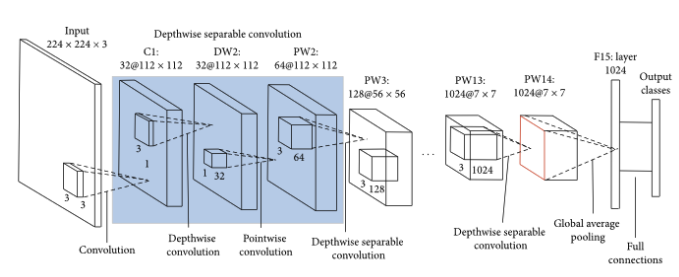

source: https://medium.com/analytics-vidhya/image-classification-with-mobilenet-cc6fbb2cd470

### 4.2 Model 4 - MobileNet

In [ ]:
# mobilenet is streamlined architecture that constructs lightweight deep convolutional neural networks and provides an efficient model for mobile and embedded vision applications
mobilenet = MobileNet(include_top=False,input_shape=(128,128,3))

for layer in mobilenet.layers:
    layer.trainable = False
    
mobilenet_model = tf.keras.models.Sequential()
mobilenet_model.add(mobilenet)
mobilenet_model.add(tf.keras.layers.Flatten())
mobilenet_model.add(tf.keras.layers.Dense(2,activation='sigmoid'))

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [ ]:
history_mobilenet = mobilenet_model.fit_generator(generator = train_gen,
                                      validation_data = valid_gen,
                                      epochs = 10,
                                      steps_per_epoch = 10,
                                      validation_steps = 10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
10/10 [==============================] - 35s 3s/step - loss: 0.2935 - accuracy: 0.9000 - val_loss: 0.0616 - val_accuracy: 0.9906
Epoch 2/10
10/10 [==============================] - 35s 4s/step - loss: 0.0383 - accuracy: 0.9906 - val_loss: 0.0229 - val_accuracy: 0.9969
Epoch 3/10
10/10 [==============================] - 35s 4s/step - loss: 0.0621 - accuracy: 0.9812 - val_loss: 0.0510 - val_accuracy: 0.9875
Epoch 4/10
10/10 [==============================] - 29s 3s/step - loss: 0.0341 - accuracy: 0.9969 - val_loss: 0.0184 - val_accuracy: 0.9969
Epoch 5/10
10/10 [==============================] - 30s 3s/step - loss: 0.0191 - accuracy: 0.9906 - val_loss: 0.0234 - val_accuracy: 0.9937
Epoch 6/10
10/10 [==============================] - 26s 3s/step - loss: 0.0425 - accuracy: 0.9937 - val_loss: 0.0068 - val_accuracy: 0.9969
Epoch 7/10
10/10 [==============================] - 31s 3s/step - loss: 0.0339 - accuracy: 0.9875 - val_loss: 0.0083 - val_accuracy: 0.9937
Epoch 8/10
10/10 [==

In [ ]:
mobilenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 4, 4, 1024)        3228864   
_________________________________________________________________
flatten_3 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 32770     
Total params: 3,261,634
Trainable params: 32,770
Non-trainable params: 3,228,864
_________________________________________________________________


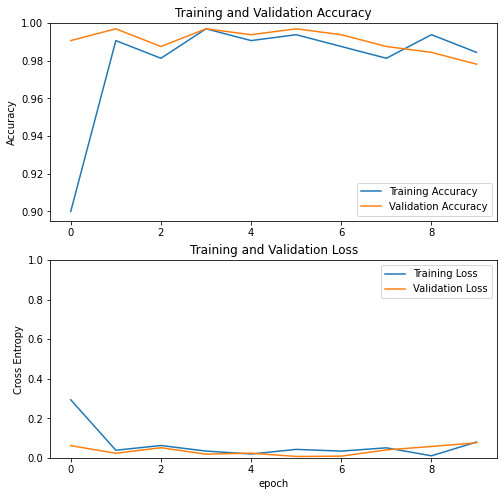

In [ ]:
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']

loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
start = time.time()
prediction4 = mobilenet_model.predict(test_gen)
end = time.time()
mobilenet_test_time = end - start

In [ ]:
mobilenet_test_time

3.268948554992676

In [ ]:
mobilenet_test_loss, mobilenet_test_acc = mobilenet_model.evaluate_generator(test_gen)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [ ]:
mobilenet_test_loss, mobilenet_test_acc

(0.06687934696674347, 0.9856054186820984)

In [ ]:
#mobilenet_model.save('mobilenet.h5')

## 5. VGG16 Model

### 5.1 VGG16 Introduction

VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. 16 refers to the number of layers using same weight.

source: https://neurohive.io/en/popular-networks/vgg16/

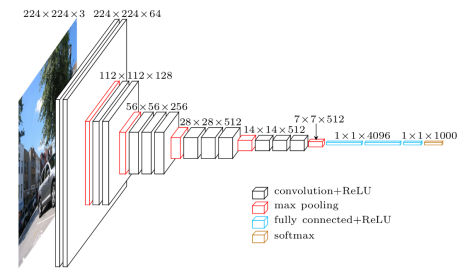

*   Convolution + ReLU: ReLU function is a supplementary step for CNN operation to increase the non-linearity of the input images/feature maps.
*   Max Pooling: It is a sample-based discretization process to down sample the input representation and reduce the dimensionality with highlighting most present features.
*   Fully-connected + ReLU: A few last layers are fully connected layers to compile the features extracted from previous steps and form the final output.
*   Softmax: softmax layers transform the real values into probabilities for the final task.

### 5.2 Model 5 - VGG16

Layer.trainable: Layers & models also feature a boolean attribute trainable. Its value can be changed. Setting layer.trainable to False moves all the layer's weights from trainable to non-trainable. This is called "freezing" the layer: the state of a frozen layer won't be updated during training (either when training with fit() or when training with any custom loop that relies on trainable_weights to apply gradient updates).

In [ ]:
# vgg16 base model
vgg = VGG16(weights='imagenet',include_top=False,input_shape=(128,128,3)) 
vgg.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

In [ ]:
vgg16 = VGG16(weights='imagenet',include_top=False,input_shape=(128,128,3)) 
# Load weights pre-trained on ImageNet. # Do not include the ImageNet classifier at the top.

for layer in vgg16.layers:
    layer.trainable = False
    
model_vgg16 = tf.keras.models.Sequential()
model_vgg16.add(vgg16)
model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(2,activation='softmax'))

Early Stopping: it acts as regularization technique and prevents the overfitting on training data, through monitoring the validation loss for whether the performance is improved in epochs, which is decided by the corresponding patience parameter.¶

In [ ]:
model_vgg16.compile(optimizer="adam",loss="binary_crossentropy",metrics ="accuracy") 
early_stopping1 = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
history_vgg16 = model_vgg16.fit_generator(generator=train_gen,
                                      validation_data=valid_gen,
                                      epochs=10,
                                      steps_per_epoch=10,
                                      validation_steps=10,
                                      callbacks=[early_stopping1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
10/10 [==============================] - 24s 2s/step - loss: 0.5271 - accuracy: 0.7531 - val_loss: 0.1961 - val_accuracy: 0.9656
Epoch 2/10
10/10 [==============================] - 20s 2s/step - loss: 0.2238 - accuracy: 0.9406 - val_loss: 0.1420 - val_accuracy: 0.9625
Epoch 3/10
10/10 [==============================] - 21s 2s/step - loss: 0.1493 - accuracy: 0.9563 - val_loss: 0.0643 - val_accuracy: 0.9812
Epoch 4/10
10/10 [==============================] - 20s 2s/step - loss: 0.0993 - accuracy: 0.9719 - val_loss: 0.0600 - val_accuracy: 0.9812
Epoch 5/10
10/10 [==============================] - 25s 2s/step - loss: 0.0999 - accuracy: 0.9594 - val_loss: 0.0342 - val_accuracy: 0.9937
Epoch 6/10
10/10 [==============================] - 22s 2s/step - loss: 0.0793 - accuracy: 0.9812 - val_loss: 0.0684 - val_accuracy: 0.9812
Epoch 7/10
10/10 [==============================] - 19s 2s/step - loss: 0.0834 - accuracy: 0.9781 - val_loss: 0.0377 - val_accuracy: 0.9844
Epoch 8/10
10/10 [==

In [ ]:
model_vgg16.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_1 (ModuleWrap (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 16386     
Total params: 14,731,074
Trainable params: 16,386
Non-trainable params: 14,714,688
_________________________________________________________________


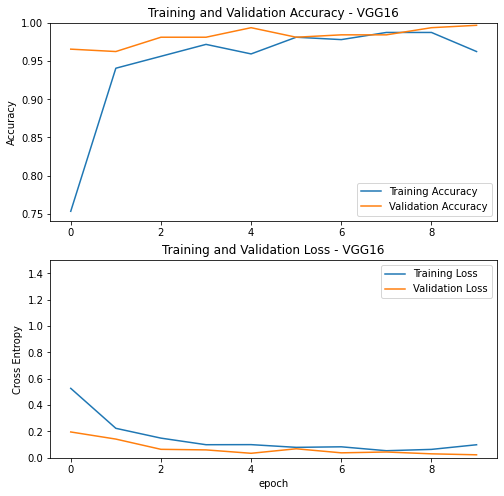

In [ ]:
acc_vgg16 = history_vgg16.history['accuracy']
val_acc_vgg16 = history_vgg16.history['val_accuracy']

loss_vgg16 = history_vgg16.history['loss']
val_loss_vgg16 = history_vgg16.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_vgg16, label='Training Accuracy')
plt.plot(val_acc_vgg16, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy - VGG16')

plt.subplot(2, 1, 2)
plt.plot(loss_vgg16, label='Training Loss')
plt.plot(val_loss_vgg16, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss - VGG16')
plt.xlabel('epoch')
plt.show()

In [ ]:
start = time.time()
prediction5 = model_vgg16.predict(test_gen)
end = time.time()
vgg16_test_time = end - start

In [ ]:
vgg16_test_time

3.9833321571350098

In [ ]:
VGG16_test_loss, VGG16_test_acc = model_vgg16.evaluate_generator(test_gen)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [ ]:
VGG16_test_loss, VGG16_test_acc

(0.03347700461745262, 0.9915326237678528)

In [ ]:
#model_vgg16.save('vgg16.h5')

## 6. VGG19 Model

### 6.1 VGG19 Introduction

VGG19 is a convolutional neural network model that also trained on ImageNet, but it is 19 layers deep and is larger networks with more parameters. It increased depth using an architecture with very small (3x3) convolution filters.

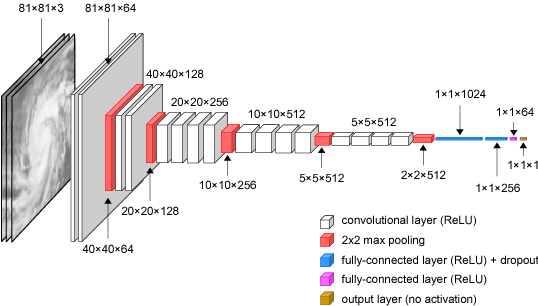

Source: Combinido, J. S., John Robert Mendoza and Jeffrey A. Aborot. “A Convolutional Neural Network Approach for Estimating Tropical Cyclone Intensity Using Satellite-based Infrared Images.” 2018 24th International Conference on Pattern Recognition (ICPR) (2018): 1474-1480.

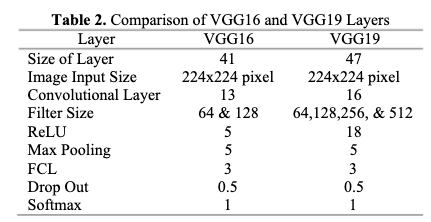

Source: Setiawan, Wahyudi & Damayanti, Fitri. (2020). Layers Modification of Convolutional Neural Network for Pneumonia Detection. Journal of Physics: Conference Series. 1477. 052055. 10.1088/1742-6596/1477/5/052055.

### 6.1 Model 6 - VGG19

The most common incarnation of transfer learning in the context of deep learning is the following workflow:

1.   Take layers from a previously trained model.
2.   Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3.   Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4.   Train the new layers on your dataset.
5.   A last, optional step, is fine-tuning, which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.

source: https://www.tensorflow.org/guide/keras/transfer_learning
source: https://keras.io/guides/transfer_learning/

In [ ]:
# vgg 19 base model
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))
vgg19.trainable = False
    
VGG19_model = tf.keras.models.Sequential()
VGG19_model.add(vgg19)
VGG19_model.add(tf.keras.layers.Flatten())
VGG19_model.add(tf.keras.layers.Dense(2,activation='softmax'))

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
VGG19_model.compile(optimizer='adam', loss='binary_crossentropy', metrics='binary_accuracy')

In [ ]:
history_VGG19 = VGG19_model.fit_generator(generator=train_gen,
                                      validation_data=valid_gen,
                                      epochs=10,
                                      steps_per_epoch=10,
                                      validation_steps=10,
                                      callbacks=[early_stopping1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
10/10 [==============================] - 20s 2s/step - loss: 0.5348 - binary_accuracy: 0.7125 - val_loss: 0.2532 - val_binary_accuracy: 0.9438
Epoch 2/10
10/10 [==============================] - 20s 2s/step - loss: 0.2555 - binary_accuracy: 0.9250 - val_loss: 0.1621 - val_binary_accuracy: 0.9563
Epoch 3/10
10/10 [==============================] - 18s 2s/step - loss: 0.1336 - binary_accuracy: 0.9688 - val_loss: 0.0968 - val_binary_accuracy: 0.9719
Epoch 4/10
10/10 [==============================] - 15s 1s/step - loss: 0.1542 - binary_accuracy: 0.9469 - val_loss: 0.1035 - val_binary_accuracy: 0.9750
Epoch 5/10
10/10 [==============================] - 13s 1s/step - loss: 0.1070 - binary_accuracy: 0.9812 - val_loss: 0.0522 - val_binary_accuracy: 0.9906
Epoch 6/10
10/10 [==============================] - 13s 1s/step - loss: 0.1256 - binary_accuracy: 0.9594 - val_loss: 0.0494 - val_binary_accuracy: 0.9875
Epoch 7/10
10/10 [==============================] - 14s 1s/step - loss: 0.09

In [ ]:
VGG19_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_2 (ModuleWrap (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


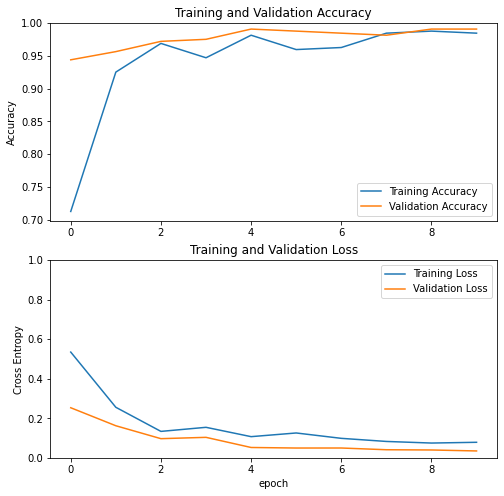

In [ ]:
acc = history_VGG19.history['binary_accuracy']
val_acc = history_VGG19.history['val_binary_accuracy']

loss = history_VGG19.history['loss']
val_loss = history_VGG19.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
start = time.time()
prediction6 = VGG19_model.predict(test_gen)
end = time.time()
vgg19_test_time = end - start

In [ ]:
VGG19_test_loss, VGG19_test_acc = VGG19_model.evaluate_generator(test_gen)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [ ]:
VGG19_test_loss, VGG19_test_acc

(0.05165672302246094, 0.9872989058494568)

In [ ]:
#VGG19_model.save('vgg19.h5')

### 6.2 Model 7 - VGG19 Model with Fine Tuning

Fine-tuning consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.

In [ ]:
# vgg19 fine tuning model: continue training on the previous fitted vgg19 model
vgg19.trainable = True

VGG19_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics='binary_accuracy')

In [ ]:
# Using EarlyStopping, end training when val_accuracy is not improved for 4 consecutive times, seek max for val_accuracy
early_stopping = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',mode='max',patience=4,restore_best_weights=True)

# Using ReduceLROnPlateau, the learning rate is reduced by half when val_accuracy is not improved for 2 consecutive times
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy',factor=0.5,patience=2,verbose=1)

# training
history_VGG19_T = VGG19_model.fit_generator(generator=train_gen,
                                    validation_data=valid_gen,
                                    epochs=10,
                                    steps_per_epoch=10,
                                    validation_steps=10,
                                    callbacks=[early_stopping,lr_scheduler])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
10/10 [==============================] - 15s 1s/step - loss: 0.0416 - binary_accuracy: 0.9875 - val_loss: 0.0305 - val_binary_accuracy: 0.9875
Epoch 2/10
10/10 [==============================] - 13s 1s/step - loss: 0.0248 - binary_accuracy: 0.9937 - val_loss: 0.0161 - val_binary_accuracy: 0.9937
Epoch 3/10
10/10 [==============================] - 13s 1s/step - loss: 0.0691 - binary_accuracy: 0.9750 - val_loss: 0.0069 - val_binary_accuracy: 0.9969
Epoch 4/10
10/10 [==============================] - 15s 1s/step - loss: 0.0397 - binary_accuracy: 0.9844 - val_loss: 0.0343 - val_binary_accuracy: 0.9875
Epoch 5/10
10/10 [==============================] - 12s 1s/step - loss: 0.0460 - binary_accuracy: 0.9937 - val_loss: 0.0301 - val_binary_accuracy: 0.9844

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 6/10
10/10 [==============================] - 14s 1s/step - loss: 0.0216 - binary_accuracy: 0.9937 - val_loss: 0.0141 - val_binary_accuracy: 0.

In [ ]:
VGG19_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_2 (ModuleWrap (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 20,040,770
Non-trainable params: 0
_________________________________________________________________


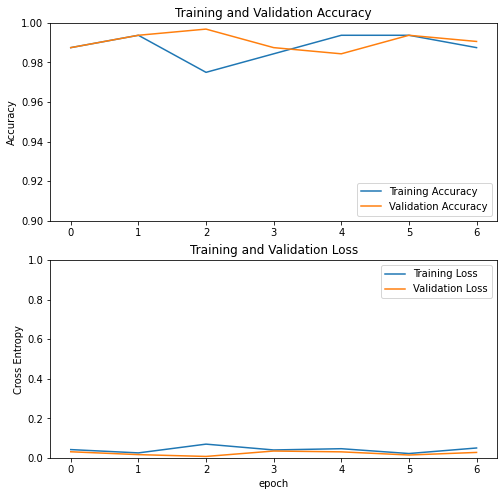

In [ ]:
acc = history_VGG19_T.history['binary_accuracy']
val_acc = history_VGG19_T.history['val_binary_accuracy']

loss = history_VGG19_T.history['loss']
val_loss = history_VGG19_T.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.9,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
start = time.time()
prediction7 = VGG19_model.predict(test_gen)
end = time.time()
vgg19_T_test_time = end - start

In [ ]:
VGG19_T_test_loss, VGG19_T_test_acc = VGG19_model.evaluate_generator(test_gen)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [ ]:
VGG19_T_test_loss, VGG19_T_test_acc

(0.030206145718693733, 0.9906858801841736)

In [ ]:
#VGG19_model.save('vgg19_T.h5')

## 7. Prediction

In [ ]:
test_results = pd.DataFrame({'Number': ['Model 1', 'Model 2','Model 3','Model 4','Model 5','Model 6','Model 7'],
                              'Model': ['CNN 1','CNN 2','CNN 3', 'MobileNet', 'VGG16', 'VGG19', 'VGG19_Tuning'], 
                              'Accuracy': [CNN_test_acc1, CNN_test_acc2, CNN_test_acc3, mobilenet_test_acc, VGG16_test_acc, VGG19_test_acc, VGG19_T_test_acc],
                              'Processing Time': [CNN_test_time1, CNN_test_time2, CNN_test_time3, mobilenet_test_time, vgg16_test_time, vgg19_test_time, vgg19_T_test_time]})
test_results
# test result shows that both vgg16 and vgg19_tuning models have high accuracy scores, and compared with the corresponding processing time, vgg19 fine tuning outperforms vgg16 

Number         Model  Accuracy  Processing Time
0  Model 1         CNN 1  0.491956       371.107202
1  Model 2         CNN 2  0.863675         2.959409
2  Model 3         CNN 3  0.938188         2.931900
3  Model 4     MobileNet  0.985605         3.268949
4  Model 5         VGG16  0.991533         3.983332
5  Model 6         VGG19  0.987299         3.175953
6  Model 7  VGG19_Tuning  0.990686         3.023132

In [ ]:
test_time= pd.DataFrame({'Number': ['Model 1', 'Model 2','Model 3','Model 4','Model 5','Model 6','Model 7'],
                              'Model': ['CNN 1','CNN 2','CNN 3', 'MobileNet', 'VGG16', 'VGG19', 'VGG19_Tuning'], 
                              'Processing Time': [CNN_test_time1, CNN_test_time2, CNN_test_time3, mobilenet_test_time, vgg16_test_time, vgg19_test_time, vgg19_T_test_time]})
test_time

Number         Model  Processing Time
0  Model 1         CNN 1       371.107202
1  Model 2         CNN 2         2.959409
2  Model 3         CNN 3         2.931900
3  Model 4     MobileNet         3.268949
4  Model 5         VGG16         3.983332
5  Model 6         VGG19         3.175953
6  Model 7  VGG19_Tuning         3.023132

In [ ]:
best_model = VGG19_model

### 7.1 Test Sample Prediction

In [ ]:
train_gen.class_indices

{'mask': 0, 'no_mask': 1}

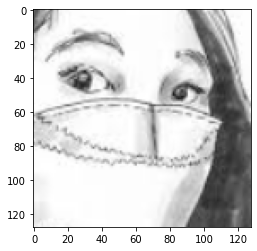

In [ ]:
#sample_mask_img = cv2.imread('/content/drive/MyDrive/Face Mask Dataset/Test/WithMask/231.png')
sample_mask_img = cv2.imread('/content/drive/MyDrive/Machine Learning/Face Mask Dataset/Test/WithMask/231.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

In [ ]:
best_model.predict(sample_mask_img)

array([[9.9984312e-01, 2.4890372e-07]], dtype=float32)

In [ ]:
pred = best_model.predict(sample_mask_img)
predicted_class_indices = np.argmax(pred,axis=1)

labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions

['mask']

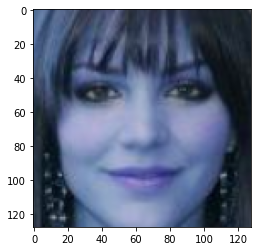

In [ ]:
#sample_mask_img = cv2.imread('/content/drive/MyDrive/Face Mask Dataset/Test/WithoutMask/379.png')
sample_mask_img = cv2.imread('/content/drive/MyDrive/Machine Learning/Face Mask Dataset/Test/WithoutMask/813.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

In [ ]:
best_model.predict(sample_mask_img)

array([[2.6570859e-07, 9.9999976e-01]], dtype=float32)

In [ ]:
pred = best_model.predict(sample_mask_img)
predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions

['no_mask']

### 7.2 Mask Detection

In [ ]:
mask_label = {0:'MASK',1:'NO MASK'}
color_label = {0:(0,255,0),1:(255,0,0)}

#### 7.2.1 Mask Detection - Example 1

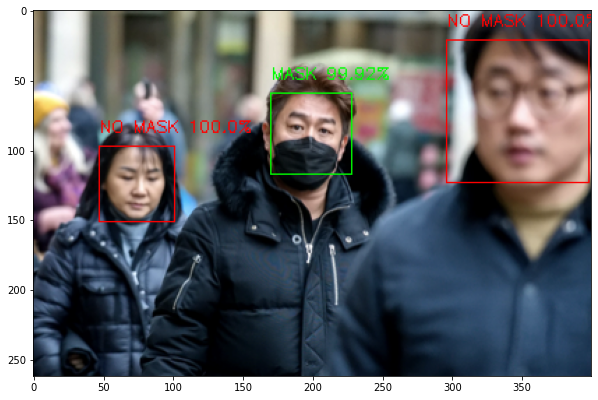

In [ ]:
if len(faces)>=2:
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0

        mask_result = best_model.predict(crop)
        cv2.putText(img = new_img, text = mask_label[mask_result.argmax()] + " " + str(round(mask_result.max()*100,2)) + "%", 
                    org = (x, y-10), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.4, color = color_label[mask_result.argmax()], thickness = 1)
        cv2.rectangle(new_img, (x,y), (x+w,y+h), color_label[mask_result.argmax()], 1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

#### 7.2.2 Mask Detection - Example 2

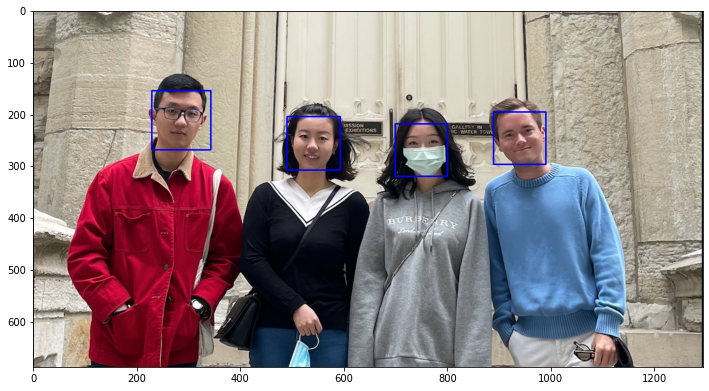

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Machine Learning/Team Photo/1.png')
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.2, minNeighbors=8) #returns a list of (x,y,w,h) tuples
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),2)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

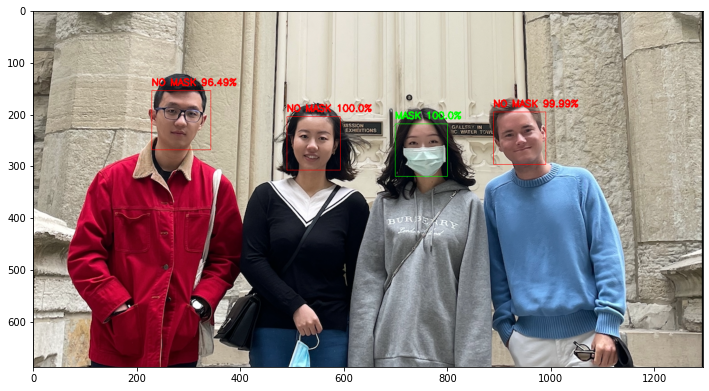

In [ ]:
if len(faces)>=2:
  new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

  for i in range(len(faces)):
      (x,y,w,h) = faces[i]
      crop = new_img[y:y+h,x:x+w]
      crop = cv2.resize(crop,(128,128))
      crop = np.reshape(crop,[1,128,128,3])/255.0

      mask_result = best_model.predict(crop)
      cv2.putText(img = new_img, text = mask_label[mask_result.argmax()] + " " + str(round(mask_result.max()*100,2)) + "%", 
                    org = (x, y-10), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.6, color = color_label[mask_result.argmax()], thickness = 2)
      cv2.rectangle(new_img, (x,y), (x+w,y+h), color_label[mask_result.argmax()], 1)
  plt.figure(figsize=(12,12))
  plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

#### 7.2.3 Mask Detection - Example 3

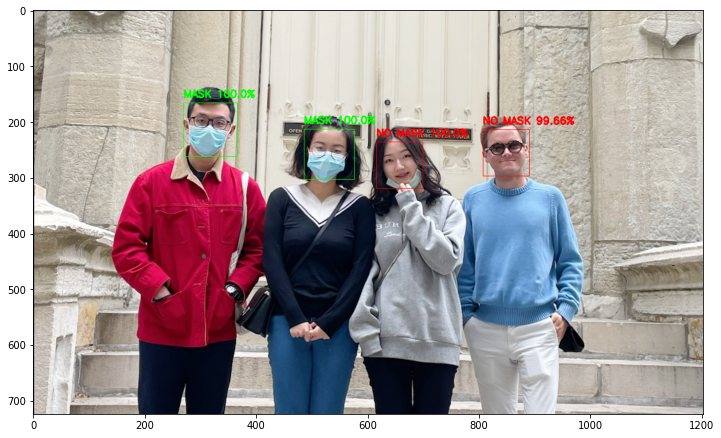

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Machine Learning/Team Photo/2.png')
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)

if len(faces)>=2:
  new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

  for i in range(len(faces)):
      (x,y,w,h) = faces[i]
      crop = new_img[y:y+h,x:x+w]
      crop = cv2.resize(crop,(128,128))
      crop = np.reshape(crop,[1,128,128,3])/255.0

      mask_result = best_model.predict(crop)
      cv2.putText(img = new_img, text = mask_label[mask_result.argmax()] + " " + str(round(mask_result.max()*100,2)) + "%", 
                    org = (x, y-10), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.6, color = color_label[mask_result.argmax()], thickness = 2)
      cv2.rectangle(new_img, (x,y), (x+w,y+h), color_label[mask_result.argmax()], 1)
  plt.figure(figsize=(12,12))
  plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

#### 7.2.4 Mask Detection - Example 4

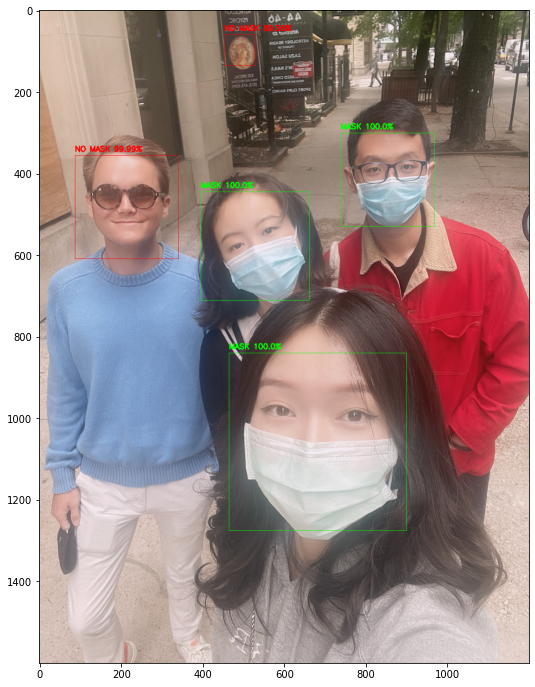

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Machine Learning/Team Photo/3.png')
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=8)

if len(faces)>=2:
  new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

  for i in range(len(faces)):
      (x,y,w,h) = faces[i]
      crop = new_img[y:y+h,x:x+w]
      crop = cv2.resize(crop,(128,128))
      crop = np.reshape(crop,[1,128,128,3])/255.0

      mask_result = best_model.predict(crop)
      cv2.putText(img = new_img, text = mask_label[mask_result.argmax()] + " " + str(round(mask_result.max()*100,2)) + "%", 
                    org = (x, y-10), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.6, color = color_label[mask_result.argmax()], thickness = 2)
      cv2.rectangle(new_img, (x,y), (x+w,y+h), color_label[mask_result.argmax()], 1)
  plt.figure(figsize=(12,12))
  plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")